In [1]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchtext

from copy import deepcopy
from IPython.display import display
from collections import defaultdict
from torchvision import datasets
from torch.distributions import Categorical, Bernoulli 
from torch.utils.data import DataLoader
from IPython.display import clear_output

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
TODO: 

1. early stop
2. output node chosing by opt_cell
3. open Self_Attn (too slow)
4. Save Model
5. Model initialization
6. add error rate
7. one more zeros and ones cell
8. Retrieve cell dict
9. add feed forward process
10. change the num_attention 
'''
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.width',2000)

# What kind of thing should I add to this algorithm? 

In [2]:
'''
1. def FetchingNAS_info():
2. early_output
3. training_single_dag
4. agent
5. add dropout?
6. NaN handling
7. useless steps
8. NALU cell for controller?
'''

'\n1. def FetchingNAS_info():\n2. early_output\n3. training_single_dag\n4. agent\n5. add dropout?\n6. NaN handling\n7. useless steps\n8. NALU cell for controller?\n'

In [3]:
'''
1. For testing the early_output = False
2. Answer the question that the actorcritic is more unstable, and the policygradient are relatively stable?
3. The elementwise-mul and bmm are allowed.
4. increase the dim? 
'''

'\n1. For testing the early_output = False\n2. Answer the question that the actorcritic is more unstable, and the policygradient are relatively stable?\n3. The elementwise-mul and bmm are allowed.\n4. increase the dim? \n'

In [4]:
def FetchingNAS_info():
    print('Dataset: ', args.img_name)
    print('Early output: ', args.early_output)
    print('Training single dag: ', args.training_single_dag)
    print('Agent: ', args.agent)
    print('Controller RNN: ', args.RNN)
    # portion

In [5]:
class args(object):
    
    ### Fetching ###
    
    # Inplace can't be used with bmm and element-wise mul simultaneously.
    
    CNN_Inplace = True
    early_output = False
    training_single_dag = True
    agent = 'PolicyGradient' # [ActorCritic, PolicyGradient]
    fetching_dim = 64
    num_weights = 5 * 3
    num_input_cells = 3
    num_iner_memories = 2
    num_cells = num_input_cells + num_iner_memories 
    num_time_steps = 8 # how many time_step
    num_bns = 3
    num_attns = 5 
    num_dropouts = 0 # should be larger than 3 
    
    num_act_fns = 4
    
    num_opts = num_weights + num_bns + num_act_fns + num_dropouts + num_attns
    
    if CNN_Inplace:
        num_putways = 2
    else:
        num_putways = 4 # [inplace, plus, elememntwise, bmm] 
        
    num_fetching_steps = 5 # [retr, opt, bn, act, retur, put, output_signal, Attn]

    emb_dim = 32
    RNN = "LSTM"# Customized, LSTM
    RNN_dim = 256
    RNN_dropout = 0 # 0 
    
    ### Data ###
    
    # img_name = 'mnist'
    
    img_name = 'cifar10'
    
    if img_name == 'cifar10':
        
        img_channel = 1
        img_size = 28
        y_dim = 10
        img_path = '../Data/mnist'
        load_norm = T.Compose([T.Resize((img_size, img_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        training_dataset = datasets.MNIST(img_path,train = True, transform = load_norm, download=False)
        test_dataset = datasets.MNIST(img_path,train = False, transform = load_norm, download=False)
        
    else:
        
        img_channel = 3
        img_size = 32
        y_dim = 10
        img_path = '../Data/cifar10'
        load_norm = T.Compose([T.Resize((img_size, img_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        training_dataset = datasets.CIFAR10(img_path,train = True, transform=load_norm, download=True)
        test_dataset = datasets.CIFAR10(img_path,train = False, transform=load_norm, download=True)

    ### Training ###
    
    eps = 1e-8
    discount = 0.9
    decay = 0.95
    epoch = 150
    batch_size = 5 # 64
    shared_lr = 0.0002
    controller_lr = 0.0002
    
    shared_maxsteps = 20 # 400
    controller_maxsteps = 20 # 2000
    
    controller_sch = False
    controller_sch_steps = 2000
    controller_sch_gamma = 0.75

    shared_sch = False
    shared_sch_steps = 2000
    shared_sch_gamma = 0.75
    
    shared_grad_norm = 0.25
    controller_grad_norm = 0.25
    
    controller_L2 = 0
    shared_L2 = 1e-7

    reward_c = 80
    nan_occr = 0
    
    count_useless = True
    useless_percentage = True
    
    if useless_percentage:
        
        useless_coef = 100 # the value of the penalty will be [0,1]
        
    else:
        
        useless_coef = 10 # the vlaue of the penalty will be the same as useless dag
    
    baseline_decay = 0.95
    val_test_steps = 5
    
    critic_coef = 0.5
    entropy_coef = 0
    
    model_name = 'FetchingNAS' 
    model_path ='./'+ model_name +'/Model/'
    
    
    
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
    
to_img= T.Compose([T.ToPILImage()])
to_tensor = T.Compose([T.ToTensor()])
load_norm = T.Compose([T.Resize((args.img_size,args.img_size)),
                       T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])

In [6]:
def filter_dags(dags, dif = False):
    
    dags_len = len(dags)
    
    observe = None
    
    # check the keep of the dags from the last one.

    for dag in reversed(dags):

        if observe is None:

            # init the observe list and 
            observe = []
            observe.append(dag['Retrieve_cell'])
            if not dag['Put'] == 'Inplace':
                observe.append(dag['Return_cell']) 
            dag['Keep'] = True
            observe = list(set(observe))

        else:

            if dag['Return_cell'] in observe:
                dag['Keep'] = True
                observe.append(dag['Retrieve_cell'])
                if not dag['Put'] == 'Inplace':
                    observe.append(dag['Return_cell']) 
                observe = list(set(observe))
            else:
                dag['Keep'] = False
                
    n_dags = [ dag for  dag in dags if dag['Keep']]
    n_len = len(n_dags)
    
    if dif:
        return n_dags , abs(dags_len - n_len) 
    else:
        return n_dags
    

In [7]:
class NeuralAccumulatorCell(nn.Module):
    
    # Feed forward but Weight decomposition
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))
        
        #init.normal_(self.W_hat)
        #init.normal_(self.M_hat)
        
    def forward(self, input):
        return F.linear(input, self.W, self.bias)


class NAC(nn.Module):
    
    def __init__(self, dims):
        '''
        dims = [input_dim + hidden_dims + output_dims]
        '''
        super().__init__()
        self.num_layers = len(dims) - 1
        
        layers = nn.ModuleList()
        layers.extend([NeuralAccumulatorCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NeuralArithmeticLogicUnitCell(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)

        init.kaiming_uniform_(self.G, a = math.sqrt(5))
        init.kaiming_uniform_(self.W, a = math.sqrt(5))

    def forward(self, input):
        
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        # m = torch.exp(F.linear(log_input, self.W, self.bias))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y


class NALU(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.num_layers = len(dims) - 1
        layers = nn.ModuleList()
        layers.extend([NeuralArithmeticLogicUnitCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NALU_LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Sequential(
            nn.Linear(input_size, 4 * hidden_size, bias=bias),
            nn.LayerNorm(4 * hidden_size),
        )
        self.h2h = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size, bias=bias),
            nn.LayerNorm(4 * hidden_size),
        )
        self.nalu_h = NALU([hidden_size, hidden_size])
        self.nalu_c = NALU([hidden_size, hidden_size])
        
#         self.apply(self.weight_init)


    # this weight init can be removed? 
    def weight_init(self,m):

        std = 1.0 / math.sqrt(self.hidden_size)
        for name, w in m.named_parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden = None):
        
        if hidden is None:
            hidden = x.new_zeros(x.size(0), self.hidden_size, requires_grad=False)
            hidden = (hidden, hidden)
            
        h, c = hidden
        
        preact = self.i2h(x) + self.h2h(h)
        
        # First: apply nalu to replace activation func
        
        # self.nalu(preact)
        
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size] 
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]
        
        # Second: Apply it in the output and hidden layer

        c_t = (c*f_t) + (i_t*g_t)

        h_t = o_t * c_t.tanh()
        
        # return x, (h_t, c_t) # LSTM
        
        # return x + self.out(h_t), (h_t + h, c_t + c) # Residule LSTM

        return  self.nalu_h(h_t + h), self.nalu_c(c_t + c) # Residule NALU

class NALU_LSTM(nn.Module):
    
    def __init__(self,input_size, hidden_sizes, bidirectional = False):
        
        super().__init__()
        self.bidirectional = bidirectional
        
        if self.bidirectional:
            self.num_dir = 2
        else:
            self.num_dir = 1
            
        self.input_size = input_size
        self.L = len(hidden_sizes)
        self.layers = nn.ModuleList()
        self.layers.extend([NALU_LSTMCell(input_size,i) for i in hidden_sizes])
        self.c0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        self.h0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        
        
    def forward(self, input):
        
        '''
        input_shape = B, S, input_size
        output_shape = B, num_dir, L, S, input_size
        hidden, cells = S * (B, hidden_dim)
        '''
        
        B,S = input.shape[:-1]
        
        outputs = torch.zeros(B, self.num_dir, self.L+1, S, self.input_size)
        outputs[:,:,0,:,:] = input.unsqueeze(1).expand_as(outputs[:,:,0,:,:])
        hiddens = []
        cells = []
    
        for i, layer in enumerate(self.layers):
            f_h, f_c = self.h0[i][0].repeat(B,1), self.c0[i][0].repeat(B,1)
            if self.bidirectional:
                i_h, i_c = self.h0[i][1].repeat(B,1), self.c0[i][1].repeat(B,1)
            for j in range(S):
                f_out, (f_h,f_c) = layer(outputs[:,0,i,j,:].clone(), (f_h,f_c))
                outputs[:,0,i+1,j,:] = f_out

            if self.bidirectional:
                for j in reversed(range(S)):
                    i_out, (i_h,i_c) = layer(outputs[:,1,i,j,:].clone(), (i_h,i_c))
                    outputs[:,1,i+1,j,:] = i_out
                hiddens.append((torch.stack([f_h,i_h])))
                cells.append(torch.stack([f_c,i_c]))
            else:
                hiddens.append(f_h)
                cells.append(f_c)
                
        #outputs = outputs[:,:,-1:,:,:]
        return outputs[:,:,1:,:,:].contiguous(), (hiddens, cells)

In [8]:
def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    '''
    Also use GAE in PPO.
    '''
    rewards = [0] * (values.size(0)-1) + [rewards]
    values = torch.cat([values,torch.tensor([[0.]]).to(device)],0)
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1]  - values[step] # Remove the gamma in here?
        gae = delta + gamma * tau * gae # -value[step] will be used in the GAE step
        returns.insert(0, gae + values[step]) # put the new one at the first, cuz we are calculating the A_GAE inversely.
    return torch.stack(returns,0) # cuz we need the gradient of value, so we have to + value[step]

In [9]:
class Controller(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        ActorCrtic For RNN
        '''
        self.retr_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.opt_emb = nn.Embedding(args.num_opts + 1, args.emb_dim)
        self.put_emb = nn.Embedding(args.num_putways, args.emb_dim)
        self.return_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.out_emb = nn.Embedding(2, args.emb_dim)
        
        self.lstm = nn.LSTMCell(args.emb_dim*args.num_fetching_steps, args.RNN_dim)
        
        self.retr_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LeakyReLU(args.RNN_dim//4),
            nn.Linear(args.RNN_dim//4, args.num_cells),
            nn.Softmax(-1),
        )
        
        self.opt_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LeakyReLU(args.RNN_dim//4),
            nn.Linear(args.RNN_dim//4, args.num_opts + 1),
            nn.Softmax(-1),
        )
        
        self.put_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LeakyReLU(args.RNN_dim//4),
            nn.Linear(args.RNN_dim//4, args.num_putways),
            nn.Softmax(-1),
        )
        
        self.return_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LeakyReLU(args.RNN_dim//4),
            nn.Linear(args.RNN_dim//4, args.num_cells),
            nn.Softmax(-1),
        )
        
        self.output_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LeakyReLU(args.RNN_dim//4),
            nn.Linear(args.RNN_dim//4, 1),
            nn.Sigmoid(),
        )
        
        self.critic = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.ReLU(),
            nn.Linear(args.RNN_dim //4, 1)
        )

        
    def forward(self, x, hidden = None ):
        
        '''
        # (Retrieve, opt(0~args.num_weight), BN(0~args.num_weight), Act_fn(0~args.num_act_fns), 
        Attn(0~args.num_Attn, Return, Put(0~args.num_putways-1))
        
        in short: [retr, opt, bn, act, attn, retur, put, output_signal]
        '''
    
        retr_e = self.retr_emb(x[:,0])
        opt_e = self.opt_emb(x[:,1])
        return_e = self.return_emb(x[:,2])
        put_e = self.put_emb(x[:,3])
        output_e = self.out_emb(x[:,4])
        
        lstm_input = torch.cat([retr_e, opt_e, return_e, put_e, output_e],1)
        
        h, c = self.lstm(lstm_input, hidden)
       
        retr_dist = Categorical(self.retr_net(h))
        opt_dist = Categorical(self.opt_net(h))
        return_dist = Categorical(self.return_net(h))
        put_dist = Categorical(self.put_net(h))
        output_dist = Bernoulli(self.output_net(h))
        
        dists = (retr_dist, opt_dist, return_dist, put_dist, output_dist)
        
        value = self.critic(h)
        
        return dists , (h,c), value
            
    def sample(self, x, hidden = None, with_detials = False):
        
        dists, hidden, value = self.forward(x, hidden)
        
        retr_dist, opt_dist, return_dist, put_dist, output_dist = dists 
        
        retr = retr_dist.sample()
        opt = opt_dist.sample()
        retur = return_dist.sample()
        put = put_dist.sample()
        output_s = output_dist.sample().squeeze(-1)

        samples = torch.stack([retr, opt, retur, put, output_s.long()],1)
        
        if with_detials:

            entropy = torch.stack([retr_dist.entropy(), opt_dist.entropy(), 
                                   return_dist.entropy(), put_dist.entropy(),
                                    output_dist.entropy().squeeze(-1)],-1)
            
            retr_logprob = retr_dist.log_prob(retr)
            opt_logprob = opt_dist.log_prob(opt)
            return_logprob = return_dist.log_prob(retur)
            put_log_prob = put_dist.log_prob(put)
            output_log_prob = output_dist.log_prob(output_s).squeeze(-1)
            
            log_probs = torch.stack([retr_logprob, opt_logprob, return_logprob, put_log_prob, output_log_prob],1)
            
            return samples, hidden, entropy, log_probs, value
        
        return samples, hidden
    
    def generate_dags(self, samples):
        
        # [retr, opt, attn, retur, put]
        
        dags = []
        
        for sample in samples:
            
            dag_dict = {}
            
            dag_dict['Retrieve_cell'] = sample[0].item()
            
            if sample[1] == 0:
                dag_dict['Operation'] = None
            else:
                dag_dict['Operation'] = sample[1].item() - 1
            
            dag_dict['Return_cell'] = sample[2].item()

            dag_dict['Put'] = sample[3].item()
            
            dag_dict['Output'] = sample[4].item()
            
            dags.append(dag_dict)
            
        return dags
    
    
    def straight_dags(self, x = None, hidden = None, num_steps = 5 , batch_size = 1, with_details = False):
        
        if x is None:
            
            x = torch.ones(batch_size,args.num_fetching_steps).to(device).long() # test the performance for ones and zeros
        
        sample_list = []
        entropies = []
        log_probs = []
        values = []
        
        for _ in range(args.num_time_steps): 
            
            if with_details:
                
                x, hidden, entropy, log_prob, value = self.sample(x, hidden, with_detials = True)
                entropies.append(entropy)
                log_probs.append(log_prob)
                values.append(value)
                
            else:
                x, hidden = self.sample(x, hidden)    
                
            sample_list.append(x)
            
        samples = torch.stack(sample_list,1)
        
        dags_dict_list_prep = []
        dags_dict_list = []
        
        for dag in samples:
#             batch_order 
            dags_dict_list_prep.append(self.generate_dags(dag))
    
        
        if args.early_output:
            
            for dag in dags_dict_list_prep[0]:
                if not dag['Output']:
                    dags_dict_list.append(dag)
                else:
                    dags_dict_list.append(dag)
                    break
                    
            dags_dict_list = [dags_dict_list]
            
        else:
            
            dags_dict_list = dags_dict_list_prep
            
        if with_details: 
            return dags_dict_list, torch.stack(entropies,1).sum(-1).squeeze().unsqueeze(-1), torch.stack(log_probs,1).squeeze(),torch.stack(values,1).squeeze().unsqueeze(-1)

        return dags_dict_list



In [10]:
class Flatten(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self,x):
        return (x.view(x.size(0),-1))

class Self_Attn(nn.Module):
    
    def __init__(self, dim):
        super(Self_Attn, self).__init__()
        
        self.dim = dim
        
        self.query_conv = nn.Conv2d(dim, dim//8, 1)
        self.key_conv = nn.Conv2d(dim, dim//8, 1)
        self.value_conv = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.sm = nn.Softmax(dim= -1)
    
    def forward(self, x):
        
        batch_size, C, width, height = x.size()
        N = width * height
        query_out = self.query_conv(x).view(batch_size, -1, N).permute(0, 2, 1) 
        key_out = self.key_conv(x).view(batch_size, -1, N) 
        attn = self.sm(torch.bmm(query_out, key_out)) 
        value_out = self.value_conv(x).view(batch_size, -1, N) 
        out = torch.bmm(value_out, attn.permute(0,2,1)).view(batch_size, C, width, height)
        out = self.gamma * out + x
        
        return out

In [11]:
class CNNCell(nn.Module):
    def __init__(self):
        super().__init__()
        
        '''
        The dim has to be more than 8
        '''
        
        self.opts = nn.ModuleList()
        self.opts.extend([nn.Conv2d(args.fetching_dim, args.fetching_dim, 3, 1, 1) for _ in range(args.num_weights)])
        self.opts.extend([nn.Conv2d(args.fetching_dim, args.fetching_dim, 1, 1, 0) for _ in range(args.num_weights)])
        self.opts.extend([nn.Conv2d(args.fetching_dim, args.fetching_dim, 5, 1, 2) for _ in range(args.num_weights)])
        
        if args.num_bns > 0:
            self.opts.append(nn.BatchNorm2d(args.fetching_dim, affine= False))
            self.opts.extend([nn.BatchNorm2d(args.fetching_dim) for _ in range(args.num_bns-1)])
        

        self.opts.extend([Self_Attn(args.fetching_dim) for _ in range(args.num_attns)])
        
        # the controller is trained to find the best validation accuracy, therefore, the reugularization has been implemented on the controller.
        # However, the dropout can help the regularization on the shared mode, hence it can be implemented on the shared model without worring abt the overfitting problem, and lead to a bad perfomance on the validation set.
        
        self.opts.extend([nn.Dropout2d(p ,inplace = True) for p in np.linspace(0.1, 0.9, args.num_dropouts)])
        
        self.opts.extend([nn.Sigmoid(),
                       nn.ReLU(inplace=True),
                       nn.LeakyReLU(0.2,inplace=True),
                       nn.Tanh(),
                      ])
        
        self.iner_memories = nn.ParameterList()
        self.iner_memories.extend([nn.Parameter(torch.randn(1,args.fetching_dim, args.img_size, args.img_size)) for _ in range(args.num_iner_memories)])
        
    def forward(self, x, dags):
        
        # cells = [x]*self.num_cells
        
        B,C,W,H = x.size()
        
        cells = [x] * (args.num_input_cells) + [m.repeat(B,1,1,1) for m in [*self.iner_memories]] 
        
        # N = W*H
        
        for i,dag in enumerate(dags):
            opting_cell = cells[dag['Retrieve_cell']].clone()
            if not dag['Operation'] is None:
                opting_cell = self.opts[dag['Operation']](opting_cell)
            if dag['Put'] == 0 :
                cells[dag['Return_cell']] = opting_cell
            elif dag['Put'] == 1:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 2 :
                cells[dag['Return_cell']] = cells[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 3:
                cells[dag['Return_cell']] = torch.bmm(opting_cell.view(-1,W,H),cells[dag['Return_cell']].view(-1,W,H).permute(0,2,1)).view(B,C,W,H)
            else: 
                raise NotImplementedError
                
            if torch.isnan(cells[dag['Return_cell']]).sum() > 0:
                args.nan_occr += 1
                print('Number of nan occur: ', torch.isnan(cells[dag['Return_cell']]).sum())
                print('The NaN portion: ', (torch.isnan(cells[dag['Return_cell']]).sum()/cells[dag['Return_cell']].nelement()))
                cells[dag['Return_cell']][torch.isnan(cells[dag['Return_cell']])] = 0
                
            if args.early_output and dag['Output']:
                return cells[dag['Return_cell']]

        return cells[dag['Return_cell']]  # or retrun the last cell 
    
    def dags_translate(self, dags_):
        dags = deepcopy(dags_)
        '''
        add one more col for operation name
        '''
        for dag in dags:
            dag['Operation_name'] = str(self.opts[dag['Operation']]) if not dag['Operation'] is None else 'None'
            if dag['Put'] == 0:
                dag['Put'] = 'Inplace'
            elif dag['Put'] == 1:
                dag['Put'] = 'Plus'
            elif dag['Put'] == 2:
                dag['Put'] = 'Emlement_Wise*'
            elif dag['Put'] == 3:
                dag['Put'] = 'Bmm'
            dag['Output'] = bool(dag['Output'])
        return dags

In [12]:
class CNNContainer(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        self.cell = CNNCell()
        
        self.cnn_st = nn.Sequential(
            nn.Conv2d(args.img_channel, args.fetching_dim, 1, 1, 0),
        )
        
        self.cnn_end = nn.Sequential(
            nn.Conv2d(args.fetching_dim, 1, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            Flatten(),
            nn.Linear(args.img_size*args.img_size, args.y_dim),
            #nn.Softmax(dim=-1),
        )
        
        self.Loss = nn.CrossEntropyLoss()
        
    def forward(self, x, dags):
        
        input_ = self.cnn_st(x)
        
        output = self.cell(input_, dags)
        
        output = self.cnn_end(output)
        
        return output
        
    def get_loss(self, loader, dags):
        
        imgs, targets = iter(loader).next()
        
        imgs = imgs.to(device)
        
        targets = targets.to(device)
            
        out = self.forward(imgs, filter_dags(dags[0]))
            
        loss = self.Loss(out, targets)
        
        return loss
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
        

In [13]:
class FetchingNAS(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.shared = CNNContainer()
        
        self.controller = Controller()
        
        self.training_loader = DataLoader(args.training_dataset,
                                    batch_size= args.batch_size,
                                    shuffle=True, drop_last = True)
        self.valid_loader = DataLoader(args.test_dataset,
                                    batch_size= args.batch_size,
                                    shuffle=True, drop_last = True)
        
        self.shared_optim = optim.Adam(self.shared.parameters(), lr = args.shared_lr, weight_decay = args.shared_L2)
        self.controller_optim = optim.Adam(self.controller.parameters(), lr = args.controller_lr, weight_decay = args.controller_L2)
        
        if args.controller_sch:
            self.controller_scheduler = optim.lr_scheduler.StepLR(self.controller_optim, args.controller_sch_steps, gamma = args.controller_sch_gamma)
            
        if args.shared_sch:
            self.shared_scheduler = optim.lr_scheduler.StepLR(self.shared_optim, args.shared_sch_steps, gamma = args.shared_sch_gamma)
        
        
        self.CE = nn.CrossEntropyLoss()
#         self.CE = nn.NLLLoss()
        self.max_R = None
        self.best_dag = None
        self.controller_hist = defaultdict(list)
        
        self.apply(self.weight_init)
        
        FetchingNAS_info()
        
    def train_shared(self,):
        
        self.shared.train()
        
        self.controller.eval()
        
        step = 0
        
        self.shared_losses = []
        
        if args.training_single_dag:
        
            dags = self.controller.straight_dags(num_steps = args.num_time_steps)
            
        while step < args.shared_maxsteps:
            
            if args.shared_sch:
                
                self.shared_scheduler.step()
            
            self.shared_optim.zero_grad()
            
            if not args.training_single_dag:
                
                dags = self.controller.straight_dags(num_steps = args.num_time_steps)
            
            loss = self.shared.get_loss(self.training_loader, dags)
            
            loss.backward()
            
            self.shared_losses.append(loss.item())
            
            if not args.shared_grad_norm is None:
                
                nn.utils.clip_grad_norm_(self.shared.parameters(), args.shared_grad_norm)
            
            self.shared_optim.step()
            
            step += 1 
    
    def get_reward(self, dags, entropies,):
        
        loss = 0
        
        i = 0
        
        for i in range(args.val_test_steps):
            
            v_loss = self.shared.get_loss(self.valid_loader, dags)
            
            if torch.isnan(v_loss):
                
                loss += torch.tensor(float('inf')).to(device)
                
            else: 
                
                loss += v_loss
                
        loss /= args.val_test_steps
        
        loss_ppl = loss.exp()
        
        R = (args.reward_c / ((loss_ppl**2) + args.eps)) # * torch.ones_like(entropies)
        
        if args.count_useless:
            
            if args.useless_percentage:
            
                R -= (self.analyse_dag(dags[0]) / args.num_time_steps) * args.useless_coef
            
            else:   
                
                R -= self.analyse_dag(dags[0]) * args.useless_coef
        
        return R
        
        # If we sample a dag a time, then change the structure of sampling dag    
            
    def train_controller(self,):
        
        self.controller.train()
        
        step = 0
        
        self.en_losses = []
    
        self.controller_losses = []
        
        self.actor_losses = []
        
        self.critic_losses = []
        
        self.real_entropies = []
        
        baseline = None
        
        while step < args.controller_maxsteps:
            
            if args.controller_sch:
                
                self.controller_scheduler.step()
            
            self.controller_optim.zero_grad()
            
            dags, entropy, log_prob, value = self.controller.straight_dags(num_steps = args.num_time_steps ,with_details = True)
        
            with torch.no_grad():
                
                R = self.get_reward(dags, entropy)
            
            if self.max_R is None:
                self.max_R = R.max()
                self.best_dag = dags[0]
            else:
                if R.max() > self.max_R:
                    self.max_R = R.max()
                    self.best_dag = dags[0]
             
            self.controller_hist['Rewards'].append(R.item())
            
            if args.agent == 'ActorCritic':
            
                returns = compute_gae(R, value)

                adv = returns.detach() - value 

                actor_loss = ( - log_prob * adv).mean()

                critic_loss = args.critic_coef * adv.pow(2).mean() 

                en_loss = args.entropy_coef * entropy.mean()

                loss = actor_loss + critic_loss - en_loss
                
            elif args.agent == 'PolicyGradient':
                
                if baseline is None:
                    
                    baseline = R
                    
                else:
                
                    baseline = args.decay * baseline + (1 - args.decay) * R

                adv = R - baseline
                
                actor_loss = ( - log_prob * adv ).mean()
                
                critic_loss = torch.tensor(0)

                en_loss = args.entropy_coef * entropy.mean()

                loss = actor_loss - en_loss
                
            else:
                
                raise NotImplementedError
                
            
            self.actor_losses.append(actor_loss.item())
            self.critic_losses.append(critic_loss.item())
            self.en_losses.append(-en_loss.item())
            self.controller_losses.append(loss.item())
            self.real_entropies.append(entropy.mean().item())
            
            step += 1
        
    
    def train(self, n_epoch, save_freq = 30):
        
        start_t = time.time()

        for self.epoch in range(n_epoch):
            
            # Trian the shared model's parameter for shared_maxsteps
            self.train_shared()
            
            # Train controller for controler_maxsteps
            self.train_controller()
            
            self.plot_controller_hist('_Rewards')
            
            end_t = time.time()
            
            self.analyse_dag(self.best_dag, True, True)
            
#             display(self.dags_df(dags_translate(self.best_dag),delete = args.early_output))
            
            print('Epoch: [%d] | Max_ Reward: [%.4f] | Lasting Time: [%.4f] | NaN Occur: [%d] '% (self.epoch, self.max_R, end_t - start_t, args.nan_occr))
            
            args.nan_occr = 0
            
            print('Controller [%.4f] | Actor [%.4f] | Critic [%.4f] | Entropy [%.4f] | R_Entropy [%.4f]' %\
                   (sum(self.controller_losses) / len(self.controller_losses),
                   (sum(self.actor_losses) /len(self.actor_losses)),
                   (sum(self.critic_losses) /len(self.critic_losses)),
                   (sum(self.en_losses) /len(self.en_losses)),
                   (sum(self.real_entropies) /len(self.real_entropies)),
                  ))
            
            print('Shared [%.4f]'%(sum(self.shared_losses)/ len(self.shared_losses)))
            
            if self.epoch % save_freq == 0 and self.epoch != 0:
                
                self.model_save('Training')
                
            
            
    def analyse_dag(self, dag, best_dag = False , verbose = False):
        
        original_df = self.dags_df(self.shared.cell.dags_translate(dag),delete = args.early_output)
        
        filtered_dag = filter_dags(dag) 
        
        if best_dag:
            
            self.filtered_best_dag = filtered_dag
        
        compressed_df = self.dags_df(self.shared.cell.dags_translate(filtered_dag),delete = args.early_output)
        
        useless = len(original_df.index)-len(compressed_df.index)
        
        if verbose:
            
            print('The Dag is:')
            display(original_df)
            print('Useless Steps: ', useless)
            print('The Compressed Dag:')
            display(compressed_df)
        
        return useless
        
    def plot_controller_hist(self, step):
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        for name in self.controller_hist.keys():
            plt.plot(self.controller_hist[name], label = name)
            plt.xlabel('Number of Steps',fontsize=15)
            plt.ylabel( name, fontsize=15)
            plt.title(name, fontsize=30, fontweight ="bold")
            plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png")
    
    def num_all_params(self,):
        
        return sum([param.nelement() for param in self.parameters()])
    
    def model_save(self, step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name: self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
    def dags_df(self, dags, delete = False):
        
        if delete:
            
            df = pd.DataFrame(dags)[['Retrieve_cell','Operation','Operation_name','Return_cell','Put','Output']]
            
            # extra dags have been removed in the process of the generating the dags.a
        
            return df 
        
        else:
            
            df = pd.DataFrame(dags)[['Retrieve_cell','Operation','Operation_name','Return_cell','Put']]
            
            return df 

    def weight_init(self,m):
        
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        if type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    print(name, 'initialised')
                    nn.init.orthogonal_(value.data)
#                     nn.init.xavier_normal_(value.data)
                if 'bias'in name:
#                     value.data.normal_()
                    l = len(value.data)
                    value[l // 4:l // 2].data.fill_(1.0)
        elif type(m) in [NALU_LSTMCell]:
            for name, value in m.named_parameters():
                if '0.weight' in name :
                    nn.init.orthogonal_(value.data)
                if '0.bias'in name:
                    l = len(value.data)
                    value[l // 4:l // 2].data.fill_(1.0)


In [14]:
FNAS = FetchingNAS().to(device)

Dataset:  cifar10
Early output:  False
Training single dag:  True
Agent:  PolicyGradient
Controller RNN:  LSTM


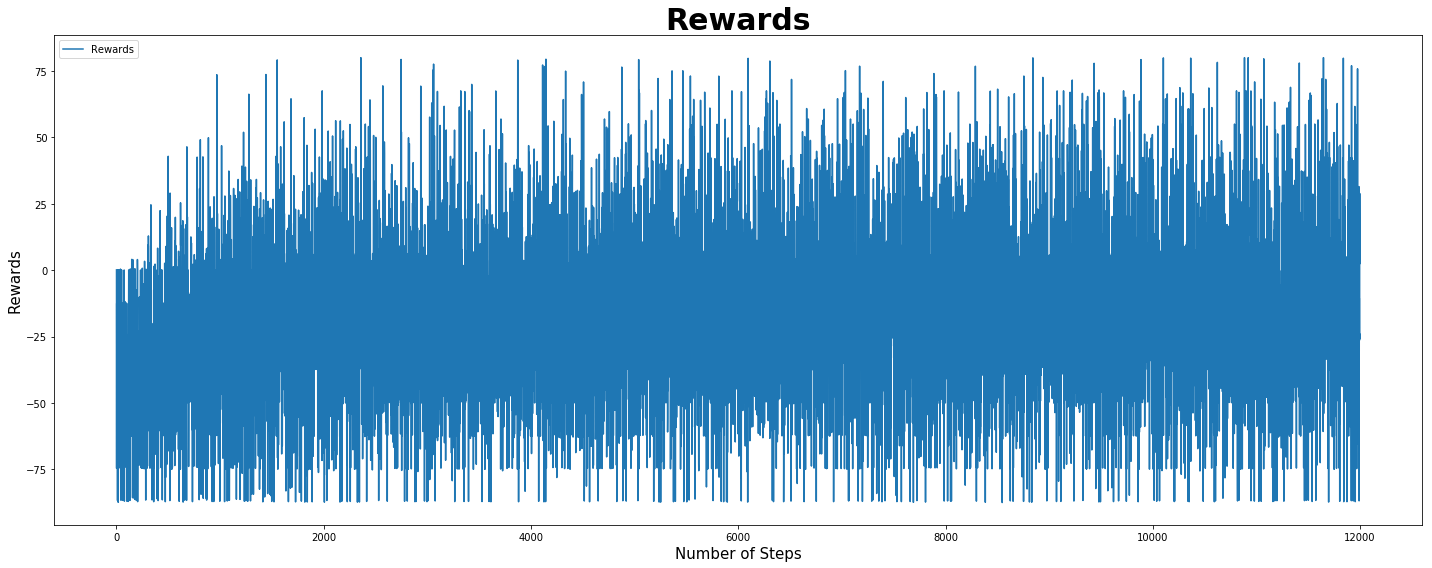

The Dag is:


,Retrieve_cell,Operation,Operation_name,Return_cell,Put
0,0,20,"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",1,Plus
1,4,5,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
2,0,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
3,0,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
4,3,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
5,4,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
6,1,4,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
7,1,5,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus


Useless Steps:  0
The Compressed Dag:


,Retrieve_cell,Operation,Operation_name,Return_cell,Put
0,0,20,"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",1,Plus
1,4,5,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
2,0,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
3,0,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
4,3,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
5,4,7,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
6,1,4,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus
7,1,5,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",0,Plus


Epoch: [599] | Max_ Reward: [79.9997] | Lasting Time: [2834.9130] | NaN Occur: [0] 
Controller [15.9618] | Actor [15.9618] | Critic [0.0000] | Entropy [0.0000] | R_Entropy [4.8186]
Shared [0.3233]


In [15]:
FNAS.train(600)

In [16]:
# the NaN still a problem for simplifiedNAS, remove bmm and element-wise? 

# Remove element-wise and bmm